In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix
from sklearn.metrics import mean_squared_error
from pyearth import Earth
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate
from patsy import dmatrix
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc, precision_score, recall_score, confusion_matrix

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import SCORERS

#Libraries for visualizing trees
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image

#import pydotplus
import time as tm

import itertools as it

# Data quality check / cleaning / preparation¶

### Cleaning - Training Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')



# Create Credit Ratings based on Investopedia Values
train['Credit_Rating'] = 0
train['Credit_Rating'] = np.where(train['Credit_Score'] == 'Good',
                          np.random.uniform(670, 730, size=len(train)),
                          train['Credit_Rating'])

train['Credit_Rating'] = np.where(train['Credit_Score'] == 'Standard',
                          np.random.uniform(580, 670, size=len(train)),
                          train['Credit_Rating'])

train['Credit_Rating'] = np.where(train['Credit_Score'] == 'Poor',
                          np.random.uniform(0, 580, size=len(train)),
                          train['Credit_Rating'])



# Drop irrelevant columns
columns_to_drop = ['Customer_ID', 'ID','Month', 'Name', 'SSN', 'Interest_Rate','Occupation',
                    'Type_of_Loan', 'Delay_from_due_date', 'Payment_Behaviour', 'Credit_History_Age', 'Credit_Score']

train.drop(columns_to_drop, axis=1, inplace=True)



# Removing invalid characters from columns
mix_type_num_col = ['Age', 'Annual_Income', 
                    'Num_of_Delayed_Payment','Changed_Credit_Limit',
                    'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance', 'Num_of_Loan']

def set_numeric_columns(features,df=None):

    df[features]=df[features].apply(lambda x: x.replace('_','',regex=True) )
    df[features]=df[features].apply(lambda x: x.str.strip())
    df[features]=df[features].apply(lambda x: x.replace('',np.nan))
    df[features[1:]]=df[features[1:]].astype('float32')
    df[features[0]]=df[features[0]].astype('int32')

set_numeric_columns(mix_type_num_col,df=train)

In [3]:
train = train.dropna()

train = train.loc[train.Credit_Mix != "_"]
train = train.loc[train.Payment_of_Min_Amount != "NM"]

train_dummies = pd.get_dummies(train)

In [4]:
y = train_dummies.Credit_Rating
X = train_dummies.drop(columns = 'Credit_Rating')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

X = X_train[X_train.columns]
y = y_train

# Base Model

In [5]:
model = DecisionTreeRegressor(random_state=1)
model.fit(X, y)

DecisionTreeRegressor(random_state=1)

In [6]:
pred = model.predict(X_test)

In [7]:
print("The RMSE of the Base Model is", np.sqrt(mean_squared_error(y_test, pred)))

The RMSE of the Base Model is 210.0136545207562


# Visualization

In [8]:
# remove outliers

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
def remove_outliers(df, columns, threshold=3):
    print(columns)
    outliers_indices = []
    for column_name in columns:
        # Calculate the Z-scores for the specified column
        z_scores = np.abs((df[column_name] - df[column_name].mean()) / df[column_name].std())
        # Identify outliers based on the threshold
        outliers_indices.extend(z_scores[z_scores > threshold].index)
    
    df_no_outliers = df.drop(outliers_indices)
    return df_no_outliers

train = remove_outliers(train, train.select_dtypes(include = numerics).columns.tolist(), threshold = 1)


['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Credit_Rating']


###  Base Model without outliers

In [9]:
train_final = pd.get_dummies(train)
y = train_final.Credit_Rating
X = train_final.drop(columns = 'Credit_Rating')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

X = X_train[X_train.columns]
y = y_train

In [10]:
model = DecisionTreeRegressor(random_state=1)
model.fit(X, y)

DecisionTreeRegressor(random_state=1)

In [11]:
pred = model.predict(X_test)

In [12]:
print("The RMSE of the Base Model is", np.sqrt(mean_squared_error(y_test, pred)))

The RMSE of the Base Model is 91.17533270911453


### distribution of the response variable

<AxesSubplot:xlabel='Credit_Rating', ylabel='Density'>

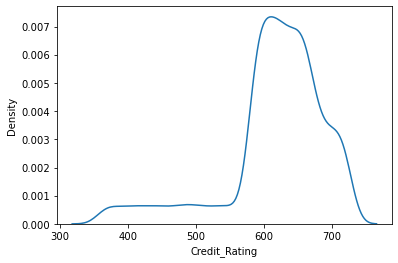

In [13]:
sns.kdeplot(train_final.Credit_Rating)

### distribution of each predictor

#### continuous

In [14]:
train_dummies.head()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Rating,Credit_Mix_Bad,Credit_Mix_Good,Credit_Mix_Standard,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes
6,23,19114.119141,1824.843333,3,4,4.0,8.0,11.27,4.0,809.979980,22.537593,49.574949,178.344070,244.565323,701.313241,0,1,0,1,0
7,23,19114.119141,1824.843333,3,4,4.0,6.0,11.27,4.0,809.979980,23.933795,49.574949,24.785217,358.124176,630.143669,0,1,0,1,0
8,28,34847.839844,3037.986667,2,4,1.0,4.0,5.42,2.0,605.030029,24.464031,18.816215,104.291824,470.690613,580.908666,0,1,0,1,0
9,28,34847.839844,3037.986667,2,4,1.0,1.0,7.42,2.0,605.030029,38.550848,18.816215,40.391239,484.591217,720.469081,0,1,0,1,0
12,28,34847.839844,3037.986667,2,4,1.0,1.0,6.42,2.0,605.030029,34.977895,18.816215,130.115417,444.867035,708.189757,0,1,0,1,0


In [15]:
train_final.head()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Rating,Credit_Mix_Bad,Credit_Mix_Good,Credit_Mix_Standard,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes
12,28,34847.839844,3037.986667,2,4,1.0,1.0,6.42,2.0,605.030029,34.977895,18.816215,130.115417,444.867035,708.189757,0,1,0,1,0
13,28,34847.839844,3037.986667,2,4,1.0,0.0,5.42,2.0,605.030029,33.381010,18.816215,43.477192,481.505249,719.488771,0,1,0,1,0
15,28,34847.839844,3037.986667,2,4,1.0,4.0,5.42,2.0,605.030029,32.933856,18.816215,218.904343,356.078094,675.179062,0,1,0,1,0
43,31,73928.460938,5988.705000,4,5,0.0,7.0,10.14,2.0,548.200012,30.201658,0.000000,618.202393,270.668121,715.519424,0,1,0,1,0
81,40,33751.269531,2948.605833,5,5,3.0,20.0,11.00,4.0,1328.930054,30.908081,65.008174,70.131081,399.721344,641.929575,0,0,1,0,1


<AxesSubplot:xlabel='Age', ylabel='Density'>

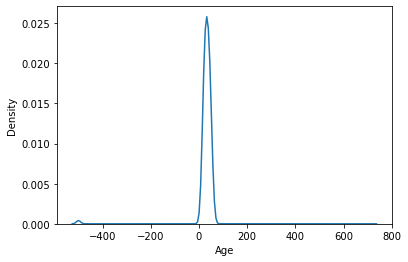

In [16]:
sns.kdeplot(train_final.Age)

<AxesSubplot:xlabel='Annual_Income', ylabel='Density'>

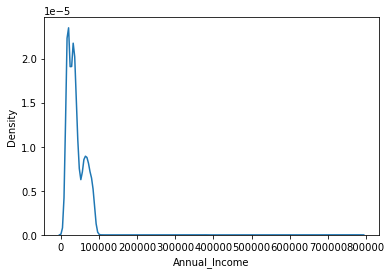

In [17]:
sns.kdeplot(train_final.Annual_Income)

<AxesSubplot:xlabel='Monthly_Inhand_Salary', ylabel='Density'>

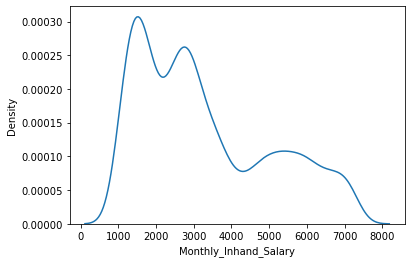

In [18]:
sns.kdeplot(train_final.Monthly_Inhand_Salary)

<AxesSubplot:xlabel='Num_Bank_Accounts', ylabel='Density'>

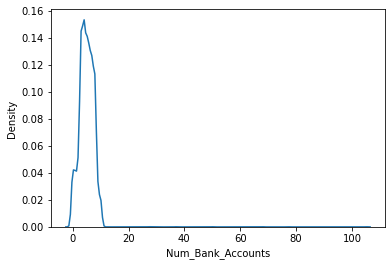

In [19]:
sns.kdeplot(train_final.Num_Bank_Accounts)

<AxesSubplot:xlabel='Num_Credit_Card', ylabel='Density'>

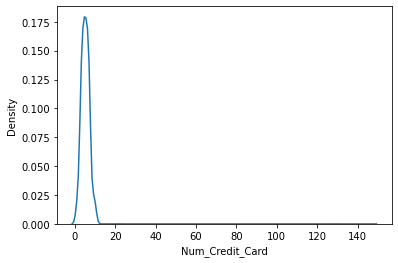

In [20]:
sns.kdeplot(train_final.Num_Credit_Card)

<AxesSubplot:xlabel='Num_of_Loan', ylabel='Density'>

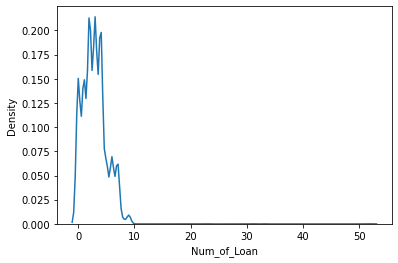

In [21]:
sns.kdeplot(train_final.Num_of_Loan)

<AxesSubplot:xlabel='Num_of_Delayed_Payment', ylabel='Density'>

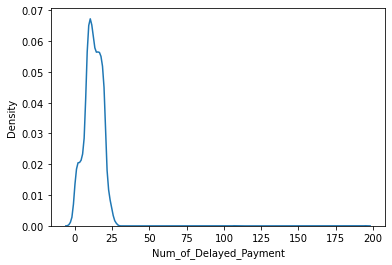

In [22]:
sns.kdeplot(train_final.Num_of_Delayed_Payment)

<AxesSubplot:xlabel='Changed_Credit_Limit', ylabel='Density'>

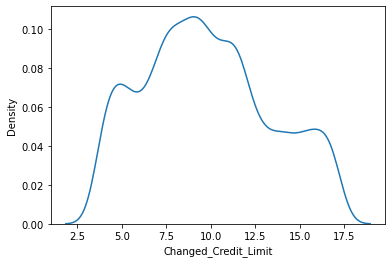

In [23]:
sns.kdeplot(train_final.Changed_Credit_Limit)

<AxesSubplot:xlabel='Num_Credit_Inquiries', ylabel='Density'>

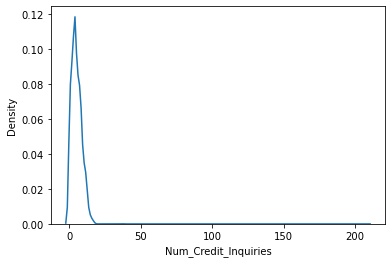

In [24]:
sns.kdeplot(train_final.Num_Credit_Inquiries)

<AxesSubplot:xlabel='Outstanding_Debt', ylabel='Density'>

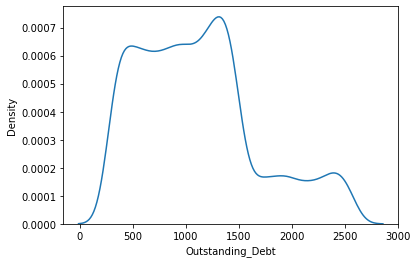

In [25]:
sns.kdeplot(train_final.Outstanding_Debt)

<AxesSubplot:xlabel='Credit_Utilization_Ratio', ylabel='Density'>

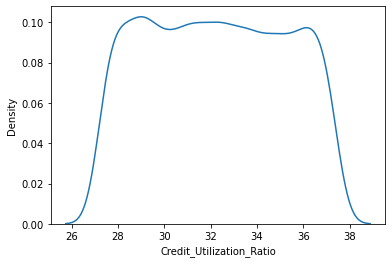

In [26]:
sns.kdeplot(train_final.Credit_Utilization_Ratio)

<AxesSubplot:xlabel='Total_EMI_per_month', ylabel='Density'>

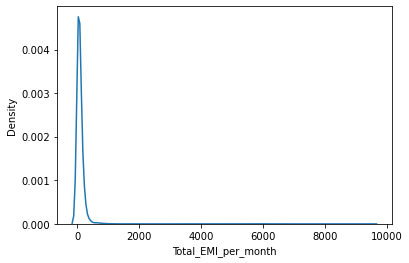

In [27]:
sns.kdeplot(train_final.Total_EMI_per_month)

<AxesSubplot:xlabel='Amount_invested_monthly', ylabel='Density'>

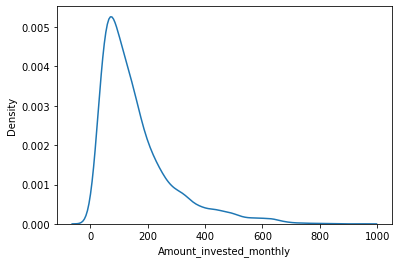

In [28]:
sns.kdeplot(train_final.Amount_invested_monthly)

<AxesSubplot:xlabel='Monthly_Balance', ylabel='Density'>

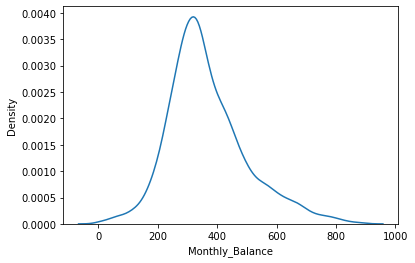

In [29]:
sns.kdeplot(train_final.Monthly_Balance)

<AxesSubplot:xlabel='Credit_Rating', ylabel='Density'>

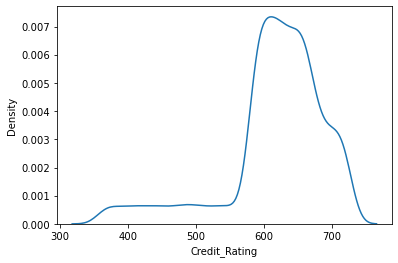

In [30]:
sns.kdeplot(train_final.Credit_Rating)

#### categorical

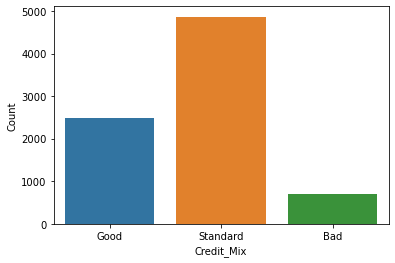

In [31]:
# Credit_Mix
sns.countplot(x='Credit_Mix', data = train)
plt.xlabel('Credit_Mix')
plt.ylabel('Count')

plt.show()

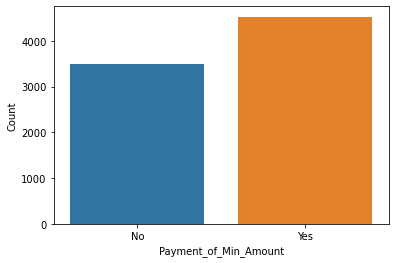

In [32]:
# Payment of Min Amount 
sns.countplot(x='Payment_of_Min_Amount', data = train)
plt.xlabel('Payment_of_Min_Amount')
plt.ylabel('Count')

plt.show()

# TRAIN DATASET IS CALLED train_final*******

In [ ]:
train_final = pd.get_dummies(train)
y = train_final.Credit_Rating
X = train_final.drop(columns = 'Credit_Rating')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

X = X_train[X_train.columns]
y = y_train

## Bagging

## Random Forest

## MARS

## XG Boost

## Ensemble Model